In [ ]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()
import statsmodels.api as sm

In [ ]:
# # import requests
# # response = requests.get('https://api.ipify.org?format=json')
# # print(response.json()['ip'])  # Prints your public IP

# from indiafactorlibrary import IndiaFactorLibrary

# # Initialize the library
# ifl = IndiaFactorLibrary()

# # Read the Fama-French 4 factors dataset
# dataset = ifl.read('ff6')

In [102]:
y = pd.read_csv('1746812133_1208bc7f9d5aff82af8d.csv', index_col='Dates', parse_dates=['Dates'])
y = y/100

In [103]:
x = pd.read_excel('MODEL A.xlsx', index_col=[0])
x = x.sub(y['RF'], axis=0)
x = x.dropna()
df = pd.concat([x,y],axis=1)
df = df.rename(columns={'MODEL A' : 'ModelA', 'MODEL B' : 'ModelB'})

In [104]:
l = pd.read_csv('Low.csv', index_col='Dates', parse_dates=['Dates'])
l = l/100
df = pd.concat([df,l],axis=1)
df

,ModelA,ModelB,MF,SMB5,HML,RMW,CMA,WML,RF,MKT,VOL,BAB_FP,BAB_FF,BAB_CAPM,IVOL
2004-10-31,NaN,NaN,0.012168,-0.006901,-0.021386,0.022337,-0.030660,0.027204,0.003877,0.016045,NaN,NaN,NaN,NaN,NaN
2004-11-30,NaN,NaN,0.094784,0.037202,0.010871,0.051777,-0.018473,0.018346,0.004361,0.099145,0.003721,0.026752,0.038386,0.022783,NaN
2004-12-31,NaN,NaN,0.089490,0.043399,0.042841,0.022424,0.029216,-0.036782,0.004866,0.094356,-0.025314,-0.016779,-0.031672,-0.013074,NaN
2005-01-31,NaN,NaN,-0.019222,-0.000578,-0.015688,0.015228,-0.009986,0.025692,0.004032,-0.015190,0.028543,-0.015173,-0.006142,0.019628,NaN
2005-02-28,NaN,NaN,0.032679,0.029722,0.047104,-0.015613,-0.007496,0.025614,0.004195,0.036874,-0.020624,0.007352,-0.023146,-0.010115,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0.011824,-0.002941,-0.021594,0.017047,-0.006544,0.003163,-0.012544,0.016039,0.005388,-0.016206,-0.030429,0.030567,-0.008735,0.004788,-0.015214
2025-01-31,-0.155133,-0.121738,-0.042245,-0.060533,0.025700,0.010120,0.004592,-0.063608,0.006013,-0.036232,0.042749,-0.019585,0.003473,-0.007968,-0.016870
2025-02-28,-0.111082,-0.076776,-0.098508,-0.062244,0.030154,-0.007777,-0.024603,-0.007605,0.004872,-0.093636,0.011661,-0.028200,-0.019134,-0.004877,-0.048734
2025-03-31,0.055635,0.079626,0.071039,-0.016809,0.008277,0.007432,-0.002740,0.045413,0.004888,0.075927,-0.000325,-0.052418,-0.015559,-0.014181,0.049159


In [106]:
def rolling_regression(df, y_col, x_cols, window=36):
    results = []

    for end in range(window, len(df)):
        start = end - window
        y = df[y_col].iloc[start:end]
        X = df[x_cols].iloc[start:end]
        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()
        coeffs = model.params
        coeffs.name = df.index[end]  # Label result with end-of-window date
        results.append(coeffs)

    return pd.DataFrame(results)

In [ ]:
# Ensure datetime index
df.index = pd.to_datetime(df.index)

cols_needed = ['ModelA', 'ModelB', 'MF', 'SMB5', 'HML', 'RMW', 'CMA', 'WML', 'VOL']
data_clean = df[cols_needed].dropna()

# Define X variables
x_factors = ['MF', 'SMB5', 'HML', 'RMW', 'CMA', 'WML', 'VOL']

# Run rolling regressions
modelA_roll = rolling_regression(data_clean, 'ModelA', x_factors, window=36)
modelB_roll = rolling_regression(data_clean, 'ModelB', x_factors, window=36)

In [108]:
modelA_roll.tail(6)

,const,MF,SMB5,HML,RMW,CMA,WML,VOL
2024-11-30,0.010683,0.565260,0.093191,0.107069,-0.997444,0.552904,0.670062,-0.035606
2024-12-31,0.009749,0.554734,0.075989,0.095049,-1.133717,0.549045,0.640354,-0.001465
2025-01-31,0.009369,0.559344,0.081822,-0.118258,-1.319550,0.603568,0.697680,0.071582
2025-02-28,0.004363,0.675942,0.234501,-0.354298,-1.031079,0.657623,1.012154,0.050307
2025-03-31,0.003319,0.833775,0.196761,-0.462347,-1.060570,0.329850,1.098352,-0.105512
2025-04-30,0.001124,0.706209,0.193517,-0.477174,-1.215916,0.293325,1.240632,0.107929


In [109]:
modelB_roll.tail(6)

,const,MF,SMB5,HML,RMW,CMA,WML,VOL
2024-11-30,0.006626,0.758670,0.100013,-0.068876,-1.488352,0.209028,0.292619,-0.036853
2024-12-31,0.003885,0.714579,0.083540,-0.188305,-1.771981,0.199488,0.334536,0.081557
2025-01-31,0.002203,0.719514,0.085187,-0.517002,-2.097668,0.289679,0.434062,0.234900
2025-02-28,-0.001852,0.806727,0.117060,-0.570766,-1.956822,0.123052,0.648601,0.241005
2025-03-31,-0.002545,0.832287,0.054480,-0.584408,-2.073708,-0.131248,0.738041,0.206952
2025-04-30,-0.005504,0.807890,0.021633,-0.438037,-1.795292,-0.339889,1.038263,0.366940


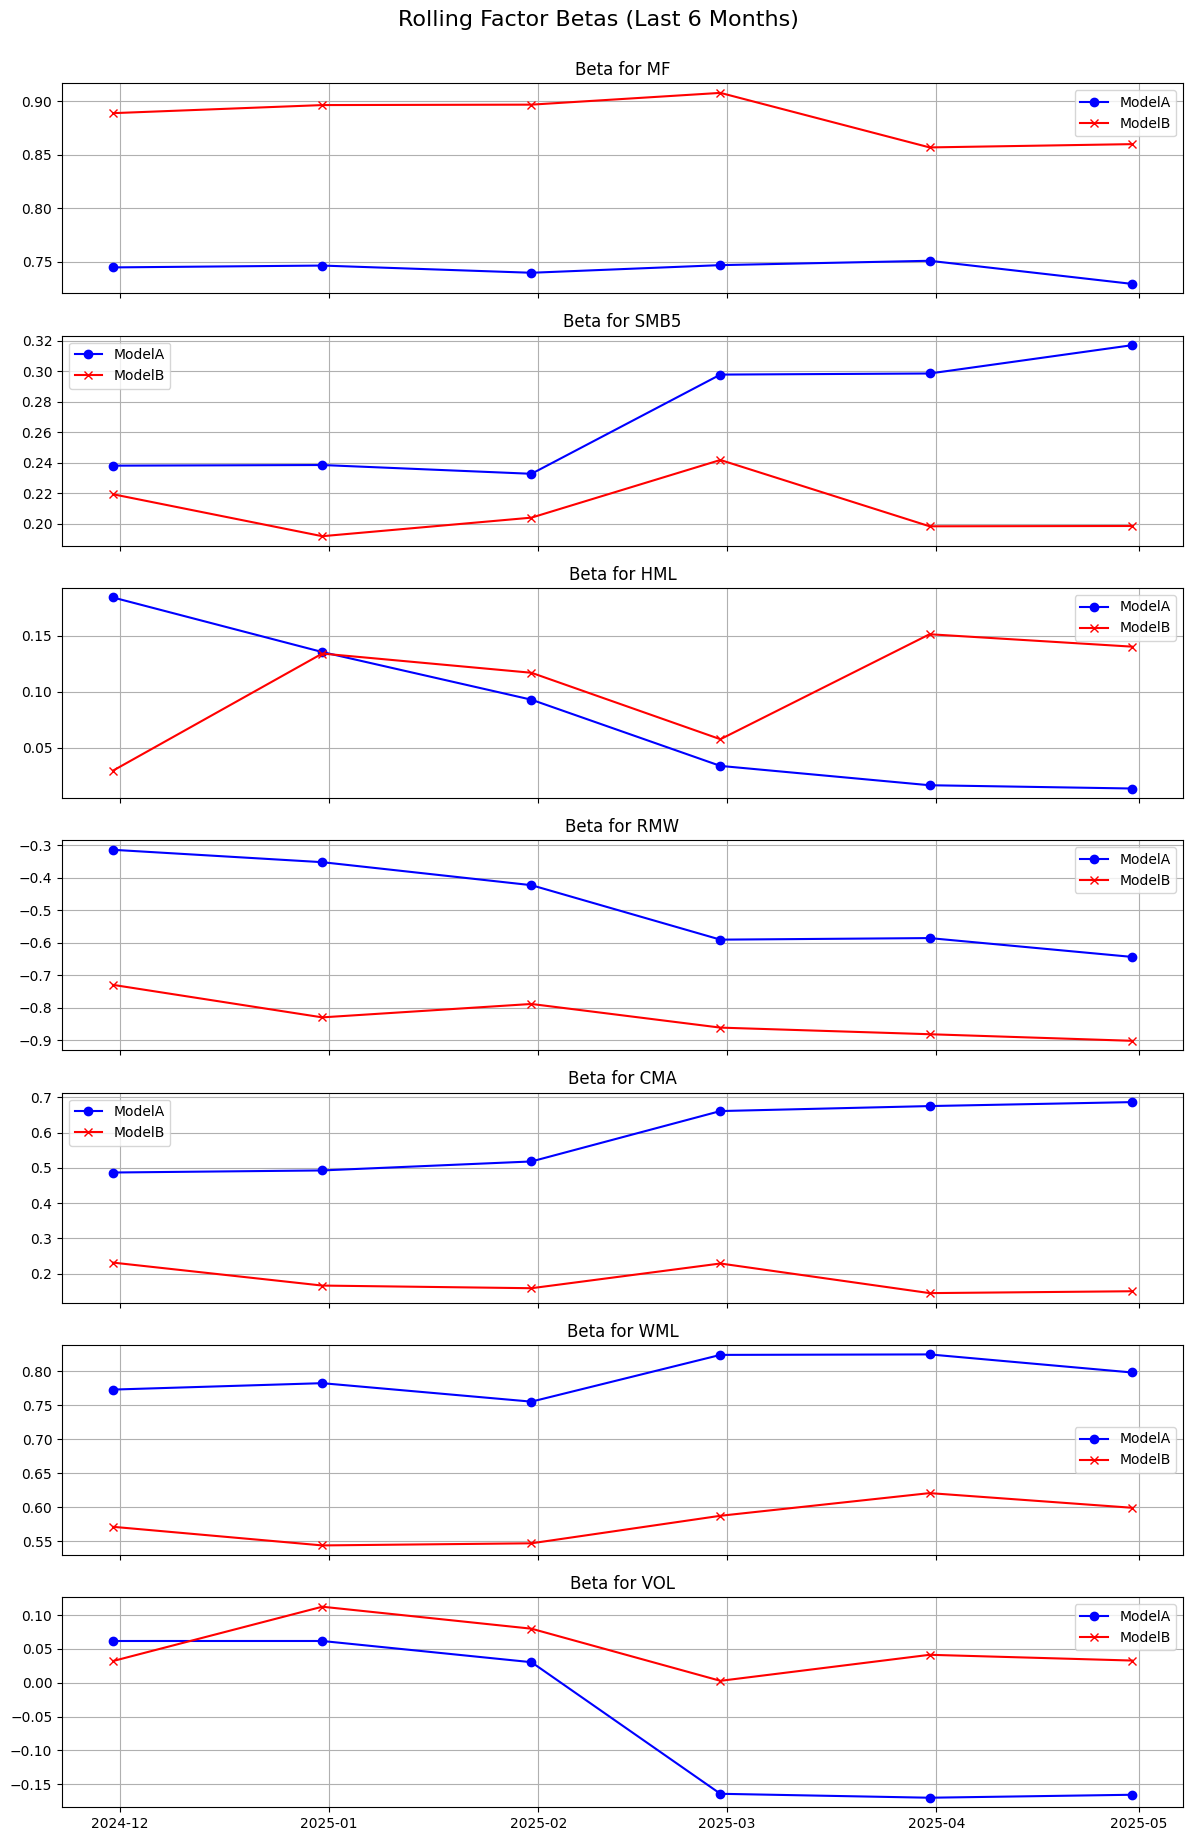

In [ ]:
# import matplotlib.pyplot as plt

# # Get last 6 months of betas
# last_6_modelA = modelA_roll.tail(6)
# last_6_modelB = modelB_roll.tail(6)

# # Plot settings
# factors = ['MF', 'SMB5', 'HML', 'RMW', 'CMA', 'WML', 'VOL']
# fig, axes = plt.subplots(len(factors), 1, figsize=(12, 18), sharex=True)

# for i, factor in enumerate(factors):
#     axes[i].plot(last_6_modelA.index, last_6_modelA[factor], label='ModelA', marker='o', color='blue')
#     axes[i].plot(last_6_modelB.index, last_6_modelB[factor], label='ModelB', marker='x', color='red')
#     axes[i].set_title(f'Beta for {factor}')
#     axes[i].legend()
#     axes[i].grid(True)

# plt.tight_layout()
# plt.suptitle('Rolling Factor Betas (Last 6 Months)', fontsize=16, y=1.02)
# plt.show()


In [ ]:
import statsmodels.formula.api as smf
for var in ['ModelA','ModelB']:
    reg = smf.ols(f'{var}~MF+SMB5+HML+RMW+CMA+WML+VOL', data=df).fit()
    print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 ModelA   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     119.8
Date:                Tue, 13 May 2025   Prob (F-statistic):           4.35e-71
Time:                        19:33:25   Log-Likelihood:                 460.90
No. Observations:                 226   AIC:                            -905.8
Df Residuals:                     218   BIC:                            -878.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0110      0.002      4.628      0.0

In [ ]:
z = pd.read_excel('IIMA.xlsx',index_col='Date', parse_dates=['Date'])
z = z/100
z = z.resample('ME').last()
x = pd.read_excel('MODEL A.xlsx', index_col=[0])
x = x.sub(z['RF'], axis=0)
x = x.dropna()
df = pd.concat([x,z],axis=1).dropna()
df = df.rename(columns={'MODEL A' : 'ModelA', 'MODEL B' : 'ModelB'})

,MODEL A,MODEL B,SMB,HML,WML,MF,RF
Date,,,,,,,
2006-07-31,0.002755,-0.012337,0.006617,-0.055262,0.057634,-0.016776,0.005283
2006-08-31,0.071202,0.085165,0.008453,0.054903,-0.001248,0.083064,0.005280
2006-09-30,0.054019,0.018178,0.004896,-0.000682,0.038175,0.047510,0.004994
2006-10-31,0.067254,0.093336,0.012448,-0.015517,0.045820,0.042340,0.005632
2006-11-30,0.043790,0.074896,0.000145,-0.015320,0.060238,0.043317,0.005299
...,...,...,...,...,...,...,...
2024-11-30,-0.006276,-0.047500,0.022122,-0.009541,0.024911,-0.007321,0.004985
2024-12-31,0.011702,-0.003063,0.018997,-0.009048,0.025988,-0.019706,0.005510
2025-01-31,-0.154557,-0.121161,-0.063259,0.013103,-0.063748,-0.050489,0.005436


In [ ]:
import statsmodels.formula.api as smf
for var in ['ModelA','ModelB']:
    reg = smf.ols(f'{var}~MF+SMB+HML+WML', data=df).fit()
    print(reg.summary())

# x = pd.read_excel('MODEL A.xlsx', index_col=[0])
# np.prod(1+ x.iloc[-4:-1])

In [ ]:
import statsmodels.api as sm
from tqdm import tqdm, trange

# ----------------------
# STEP 1: Prepare Data
# ----------------------

# Ensure datetime
# Pivot aqua to get symbol time series
symbol_prices = aqua.pivot(index='Date', columns='Symbol', values='Close')

# Align dates with regime factors
common_dates = symbol_prices.index.intersection(regime_df.index)
symbol_prices = symbol_prices.loc[common_dates]
regime_factors = regime_df.loc[common_dates]

# Compute daily log returns
symbol_returns = np.log(symbol_prices / symbol_prices.shift(1)).dropna()

# Optionally compute factor returns (recommended)
regime_returns = regime_factors.pct_change().dropna()

# Re-align both after differencing
common_dates = symbol_returns.index.intersection(regime_returns.index)
symbol_returns = symbol_returns.loc[common_dates]
regime_returns = regime_returns.loc[common_dates]

# ----------------------
# STEP 2: Rolling Regression Function
# ----------------------

def rolling_factor_betas(target_series, factor_df, window=126):
    betas = pd.DataFrame(index=target_series.index, columns=factor_df.columns)

    for i in trange(window, len(target_series), desc="Rolling windows", leave=False):
        y = target_series.iloc[i - window:i]
        X = factor_df.iloc[i - window:i]
        
        if y.isnull().any() or X.isnull().any().any():
            continue  # Skip if any missing data

        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        betas.iloc[i] = model.params[1:]  # Exclude constant

    return betas.astype(float)

# ----------------------
# STEP 3: Run for All Symbols
# ----------------------

all_betas = []

for symbol in tqdm(symbol_returns.columns, desc="Processing symbols"):
    series = symbol_returns[symbol]
    betas = rolling_factor_betas(series, regime_returns, window=126)
    betas['Symbol'] = symbol
    all_betas.append(betas)

# ----------------------
# STEP 4: Combine Results
# ----------------------

beta_df = pd.concat(all_betas)
beta_df = beta_df.reset_index()

# Now beta_df contains 6-month rolling factor betas for each symbol on each date
beta_df

In [2]:
x = pd.read_csv('Dynamic Model Portfolio_Top50.csv')
df = x[x['Date'] == '2025-05-05'].sort_values(by='Rank', ascending = True).head(40)
df = df[['Date','Symbol']]
df1 = pd.read_excel('AQUASymbols.xlsx')

In [38]:
price_data = pd.read_csv('stockPriceData-3.csv')
# Convert 'Date' to datetime type
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data = price_data.sort_values(by=['Date','Mcap'], ascending= [True,False])

In [39]:
# Filter for dates from 2006 onwards and symbols in df1
aqua = price_data[
    (price_data['Date'] >= '2006-01-01') &
    (price_data['Symbol'].isin(df1['Symbol']))]
aqua = aqua[['Date','Symbol','Close']]
aqua

,Date,Symbol,Close
4675047,2006-01-02,NTPC,92.500000
3090531,2006-01-02,INFY,186.209375
6612912,2006-01-02,TCS,210.950000
7361051,2006-01-02,WIPRO,51.941250
944917,2006-01-02,BHARTIARTL,153.628790
...,...,...,...
1263616,2025-05-06,CHAMBLFERT,726.650000
1863759,2025-05-06,EMAMILTD,627.350000
1137592,2025-05-06,CAMS,3607.900000
360297,2025-05-06,ANANTRAJ,443.000000


In [40]:
# Filter for dates from 2006 onwards and symbols in df1
model = price_data[
    (price_data['Date'] >= '2006-01-01') &
    (price_data['Symbol'].isin(df['Symbol']))]
model = model[['Date','Symbol','Close']]
model

,Date,Symbol,Close
5438796,2006-01-02,RELIANCE,90.387295
2861751,2006-01-02,ICICIBANK,108.545455
2633745,2006-01-02,HDFCBANK,71.345000
721310,2006-01-02,BAJAJHLDNG,2004.750000
1060330,2006-01-02,BPCL,36.612500
...,...,...,...
1458217,2025-05-06,CUB,181.220000
5398272,2025-05-06,RBLBANK,197.190000
2814335,2025-05-06,HOMEFIRST,1152.100000
663038,2025-05-06,AVANTIFEED,854.500000


In [41]:
import os
import glob

# Define the folder path containing the CSV files
folder_path = 'factor_nav_7_5_2025'  # Update the folder path if necessary

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# List to store individual cleaned DataFrames
regimecleaned_dataframes = []

# Load and clean each CSV file
for file in csv_files:
    df = pd.read_csv(file)
    # Drop 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    # Convert 'Date' column to datetime if present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    regimecleaned_dataframes.append(df)

# Check if any DataFrame was loaded
if not regimecleaned_dataframes:
    raise ValueError("No CSV files found in the folder.")

# Start with the first DataFrame
regime_df = regimecleaned_dataframes[0]

# Merge all DataFrames on the 'Date' column using an outer join
for df in regimecleaned_dataframes[1:]:
    regime_df = pd.merge(regime_df, df, on='Date', how='outer')

# Ensure 'Date' is in datetime format
regime_df['Date'] = pd.to_datetime(regime_df['Date'], errors='coerce')

# Optionally, drop rows with missing values (if needed)
# regime_df = regime_df.dropna()

# Optionally, set 'Date' as the index
regime_df.set_index('Date', inplace=True)

regime_df = regime_df[['QualityAnnualConsol','AM','ValueABS','LowVol','GrowthConsol']]
regime_df

,QualityAnnualConsol,AM,ValueABS,LowVol,GrowthConsol
Date,,,,,
2006-03-31,100.000000,100.000000,100.000000,100.000000,100.000000
2006-04-03,102.640474,102.372380,102.640474,101.703818,102.640474
2006-04-04,102.978602,103.177748,102.978602,102.479174,102.978602
2006-04-05,104.375147,104.662990,104.375147,103.473895,104.375147
2006-04-07,103.141888,103.561128,103.141888,102.764471,103.141888
...,...,...,...,...,...
2025-04-29,1014.277581,2033.681947,1906.574643,1051.236832,1305.945066
2025-04-30,1004.324030,2008.975829,1886.096706,1051.079045,1285.159331
2025-05-02,998.367600,2011.065700,1882.730995,1044.322235,1286.818171


Index(['ThemeUltraShortAM', 'ThemeShortAM', 'ShiftedAM', 'ThemeDownVol',
       'ThemeLowBeta', 'ValuePrice', 'ThemeAvgVol', 'Dividend', 'Mcap',
       'UltraShortAM', 'SectorValueYield', 'ShortSectorAM', 'SectorTrendMR',
       'ValueYieldNoPeg', 'QualityAnnual', 'SectorLowBeta',
       'SectorGrowthConsol', 'SectorDownVol', 'ThemeEM', 'ThemeTrendMR',
       'SectorAM', 'ThemeValueYield', 'EM', 'QualityAnnualConsol',
       'SectorLowVol', 'Theme', 'LTM', 'Growth', 'LongAM', 'ValueABSExDiv',
       'ThemeLTM', 'LowVol', 'SectorGrowth', 'LTMA', 'ValueYieldExDiv',
       'AntiTrendMR', 'TrendMR', 'ValueYield', 'SectorValuePrice', 'Sector',
       'HighBeta', 'QualityQuarter', 'ThemeHighBeta', 'SectorAvgVol', 'AM',
       'GrowthConsol', 'MidSectorAM', 'MidAM', 'SectorAntiTrendMR', 'ShortAM',
       'SectorValueABS', 'LowBeta', 'DownVol', 'ThemeGrowthConsol',
       'QualityQuarterConsol', 'AvgVol', 'ThemeAntiTrendMR', 'ThemeLowVol',
       'ThemeMidAM', 'ValueABSNoPeg', 'MCAP_Type', 'Th

In [47]:
import statsmodels.api as sm
from tqdm import tqdm, trange

# ----------------------
# STEP 1: Prepare Data
# ----------------------

# Ensure datetime
aqua['Date'] = pd.to_datetime(aqua['Date'])
regime_df.index = pd.to_datetime(regime_df.index)

# Pivot aqua to get symbol time series
symbol_prices = aqua.pivot(index='Date', columns='Symbol', values='Close')

# Align dates with regime factors
common_dates = symbol_prices.index.intersection(regime_df.index)
symbol_prices = symbol_prices.loc[common_dates]
regime_factors = regime_df.loc[common_dates]

# Compute daily log returns
symbol_returns = np.log(symbol_prices / symbol_prices.shift(1)).dropna()

# Optionally compute factor returns (recommended)
regime_returns = regime_factors.pct_change().dropna()

# Re-align both after differencing
common_dates = symbol_returns.index.intersection(regime_returns.index)
symbol_returns = symbol_returns.loc[common_dates]
regime_returns = regime_returns.loc[common_dates]

# ----------------------
# STEP 2: Rolling Regression Function
# ----------------------

def rolling_factor_betas(target_series, factor_df, window=126):
    betas = pd.DataFrame(index=target_series.index, columns=factor_df.columns)

    for i in trange(window, len(target_series), desc="Rolling windows", leave=False):
        y = target_series.iloc[i - window:i]
        X = factor_df.iloc[i - window:i]
        
        if y.isnull().any() or X.isnull().any().any():
            continue  # Skip if any missing data

        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        betas.iloc[i] = model.params[1:]  # Exclude constant

    return betas.astype(float)

# ----------------------
# STEP 3: Run for All Symbols
# ----------------------

all_betas = []

for symbol in tqdm(symbol_returns.columns, desc="Processing symbols"):
    series = symbol_returns[symbol]
    betas = rolling_factor_betas(series, regime_returns, window=126)
    betas['Symbol'] = symbol
    all_betas.append(betas)

# ----------------------
# STEP 4: Combine Results
# ----------------------

beta_df = pd.concat(all_betas)
beta_df = beta_df.reset_index()

# Now beta_df contains 6-month rolling factor betas for each symbol on each date
beta_df

Processing symbols: 100%|██████████| 40/40 [00:09<00:00,  4.10it/s]


,Date,QualityAnnualConsol,AM,ValueABS,LowVol,GrowthConsol,Symbol
0,2022-11-23,NaN,NaN,NaN,NaN,NaN,ABCAPITAL
1,2022-11-24,NaN,NaN,NaN,NaN,NaN,ABCAPITAL
2,2022-11-25,NaN,NaN,NaN,NaN,NaN,ABCAPITAL
3,2022-11-28,NaN,NaN,NaN,NaN,NaN,ABCAPITAL
4,2022-11-29,NaN,NaN,NaN,NaN,NaN,ABCAPITAL
...,...,...,...,...,...,...,...
24075,2025-04-29,0.304881,-0.101577,0.045601,0.884972,-0.054451,WIPRO
24076,2025-04-30,0.291475,-0.113267,0.035242,0.881167,-0.014575,WIPRO
24077,2025-05-02,0.290400,-0.117305,0.042467,0.893006,-0.023027,WIPRO
24078,2025-05-05,0.234616,-0.113874,0.026733,0.896728,0.024142,WIPRO


In [55]:
liveexpsoures = beta_df[beta_df['Date'] == '2025-05-05'].sort_values(by='ValueABS', ascending=False)

In [56]:
import statsmodels.api as sm
from tqdm import tqdm, trange

# ----------------------
# STEP 1: Prepare Data
# ----------------------

# Ensure datetime
model['Date'] = pd.to_datetime(model['Date'])
regime_df.index = pd.to_datetime(regime_df.index)

# Pivot aqua to get symbol time series
symbol_prices = model.pivot(index='Date', columns='Symbol', values='Close')

# Align dates with regime factors
common_dates = symbol_prices.index.intersection(regime_df.index)
symbol_prices = symbol_prices.loc[common_dates]
regime_factors = regime_df.loc[common_dates]

# Compute daily log returns
symbol_returns = np.log(symbol_prices / symbol_prices.shift(1)).dropna()

# Optionally compute factor returns (recommended)
regime_returns = regime_factors.pct_change().dropna()

# Re-align both after differencing
common_dates = symbol_returns.index.intersection(regime_returns.index)
symbol_returns = symbol_returns.loc[common_dates]
regime_returns = regime_returns.loc[common_dates]

# ----------------------
# STEP 2: Rolling Regression Function
# ----------------------

def rolling_factor_betas(target_series, factor_df, window=126):
    betas = pd.DataFrame(index=target_series.index, columns=factor_df.columns)

    for i in trange(window, len(target_series), desc="Rolling windows", leave=False):
        y = target_series.iloc[i - window:i]
        X = factor_df.iloc[i - window:i]
        
        if y.isnull().any() or X.isnull().any().any():
            continue  # Skip if any missing data

        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        betas.iloc[i] = model.params[1:]  # Exclude constant

    return betas.astype(float)

# ----------------------
# STEP 3: Run for All Symbols
# ----------------------

all_betas = []

for symbol in tqdm(symbol_returns.columns, desc="Processing symbols"):
    series = symbol_returns[symbol]
    betas = rolling_factor_betas(series, regime_returns, window=126)
    betas['Symbol'] = symbol
    all_betas.append(betas)

# ----------------------
# STEP 4: Combine Results
# ----------------------

beta_df = pd.concat(all_betas)
beta_df = beta_df.reset_index()

# Now beta_df contains 6-month rolling factor betas for each symbol on each date
beta_df

Processing symbols: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


,Date,QualityAnnualConsol,AM,ValueABS,LowVol,GrowthConsol,Symbol
0,2021-12-24,NaN,NaN,NaN,NaN,NaN,ASAHIINDIA
1,2021-12-27,NaN,NaN,NaN,NaN,NaN,ASAHIINDIA
2,2021-12-28,NaN,NaN,NaN,NaN,NaN,ASAHIINDIA
3,2021-12-29,NaN,NaN,NaN,NaN,NaN,ASAHIINDIA
4,2021-12-30,NaN,NaN,NaN,NaN,NaN,ASAHIINDIA
...,...,...,...,...,...,...,...
33075,2025-04-29,-0.089281,0.751854,-0.522728,1.106516,-0.235348,UNITDSPR
33076,2025-04-30,-0.097212,0.760516,-0.516311,1.114030,-0.249927,UNITDSPR
33077,2025-05-02,-0.130948,0.785994,-0.525435,1.129672,-0.250583,UNITDSPR
33078,2025-05-05,-0.132573,0.781716,-0.533656,1.140651,-0.241888,UNITDSPR


In [ ]:
modelexposures = beta_df[beta_df['Date'] == '2025-05-05'].sort_values(by='ValueABS', ascending=False)

In [63]:
# Assuming your model DataFrame is called 'model_df'
model_betas = modelexposures.drop(columns='Symbol')  # Dropping the Symbol column to focus on betas
model_avg_beta = model_betas.mean()  # This gives the average beta profile of the model portfolio
model_avg_beta

Date                   2025-05-05 00:00:00
QualityAnnualConsol               0.342444
AM                                0.091212
ValueABS                          0.142474
LowVol                            0.229021
GrowthConsol                      0.153539
dtype: object

In [71]:
live_betas = liveexpsoures.drop(columns='Symbol')  # Dropping the Symbol column to focus on betas
live_avg_beta = live_betas.mean()  # This gives the average beta profile of the model portfolio
live_avg_beta

Date                   2025-05-05 00:00:00
QualityAnnualConsol               0.119155
AM                                0.249581
ValueABS                          0.198891
LowVol                            0.423834
GrowthConsol                      0.090472
dtype: object

In [73]:
modelexposures

,Date,QualityAnnualConsol,AM,ValueABS,LowVol,GrowthConsol,Symbol
6614,2025-05-05,0.485210,-0.013619,1.224008,-0.129406,-0.606736,BPCL
14884,2025-05-05,1.140849,-0.304161,0.875494,-0.751713,0.213570,HAL
8268,2025-05-05,0.647722,0.163197,0.774845,0.006306,-0.275465,CHAMBLFERT
26462,2025-05-05,-0.270379,-0.537170,0.691819,0.204548,0.914888,RBLBANK
13230,2025-05-05,0.177574,0.172793,0.628386,0.550385,-0.398821,GLAXO
21500,2025-05-05,0.020350,0.423761,0.625593,0.627044,-0.371079,LTF
22327,2025-05-05,1.532294,-0.670623,0.583517,-1.321489,0.915665,MAZDOCK
4960,2025-05-05,0.173093,0.097436,0.523254,0.741969,-0.546161,AXISBANK
28943,2025-05-05,-0.231587,0.329106,0.496584,0.796767,-0.482870,SBILIFE
9922,2025-05-05,0.215130,0.046430,0.494715,0.175024,-0.078291,CUB


In [ ]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_portfolio_alignment(live_exposures, model_exposures, factors=None, threshold_method='iqr', threshold_value=1.5):
    """
    Analyze how well the live portfolio aligns with the model portfolio based on factor exposures.
    
    Parameters:
    -----------
    live_exposures : DataFrame
        DataFrame containing factor exposures for the live portfolio
    model_exposures : DataFrame
        DataFrame containing factor exposures for the model portfolio
    factors : list, optional
        List of factor names to use (columns in both DataFrames)
    threshold_method : str, optional
        Method to determine outliers: 'iqr' (interquartile range) or 'std' (standard deviation)
    threshold_value : float, optional
        Multiplier for IQR or std dev to determine outlier threshold
        
    Returns:
    --------
    DataFrame with distances and outlier flags for each stock in the live portfolio
    """
    # If factors are not specified, use all numeric columns except Date and index
    if factors is None:
        numeric_cols = live_exposures.select_dtypes(include=[np.number]).columns
        factors = [col for col in numeric_cols if col not in ['Date']]
    
    # Calculate the centroid (mean) of the model portfolio
    model_centroid = model_exposures[factors].mean()
    
    # Calculate the standard deviation of each factor in the model portfolio
    model_std = model_exposures[factors].std()
    
    # For stocks in live portfolio, calculate standardized distances from model centroid
    # First, standardize factor values using model portfolio statistics
    standardized_factors = pd.DataFrame()
    
    for factor in factors:
        if model_std[factor] > 0:  # Avoid division by zero
            standardized_factors[factor] = (live_exposures[factor] - model_centroid[factor]) / model_std[factor]
        else:
            standardized_factors[factor] = live_exposures[factor] - model_centroid[factor]
    
    # Calculate Euclidean distance in standardized space
    distances = np.sqrt((standardized_factors ** 2).sum(axis=1))
    
    # Prepare results DataFrame
    results = live_exposures[['Symbol']].copy()
    results['distance'] = distances
    
    # Add factor-specific z-scores to results
    for factor in factors:
        results[f'{factor}_zscore'] = standardized_factors[factor]
    
    # Determine outliers based on specified method
    if threshold_method == 'iqr':
        q1 = np.percentile(distances, 25)
        q3 = np.percentile(distances, 75)
        iqr = q3 - q1
        threshold = q3 + threshold_value * iqr
        results['is_outlier'] = distances > threshold
    else:  # 'std' method
        mean_dist = np.mean(distances)
        std_dist = np.std(distances)
        threshold = mean_dist + threshold_value * std_dist
        results['is_outlier'] = distances > threshold
    
    # Sort by distance (descending)
    results = results.sort_values(by='distance', ascending=False)
    
    # Add threshold value to results metadata
    results.attrs['threshold'] = threshold
    
    return results

def plot_distance_distribution(results):
    """
    Plot the distribution of distances and mark the outliers.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with KDE
    sns.histplot(results['distance'], kde=True)
    
    # Add a vertical line for the threshold
    threshold = results.attrs.get('threshold', None)
    if threshold is not None:
        plt.axvline(x=threshold, color='red', linestyle='--', 
                   label=f'Outlier Threshold ({threshold:.2f})')
    
    plt.title('Distribution of Distances from Model Portfolio', fontsize=14)
    plt.xlabel('Distance (Standardized)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

def plot_factor_contributions(results, factors, num_stocks=10):
    """
    Plot the factor contributions for the top N most distant stocks.
    """
    # Get top N stocks by distance
    top_n = results.head(num_stocks)
    
    # Extract z-score columns
    zscore_cols = [f for f in results.columns if f.endswith('_zscore')]
    
    # Create a heatmap
    plt.figure(figsize=(12, 8))
    heatmap_data = top_n[zscore_cols].set_index(top_n['Symbol'])
    
    # Rename columns to remove the _zscore suffix
    heatmap_data.columns = [col.replace('_zscore', '') for col in heatmap_data.columns]
    
    # Plot heatmap
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.2f')
    plt.title('Factor Z-Scores for Most Distant Stocks', fontsize=14)
    plt.ylabel('Stock Symbol', fontsize=12)
    plt.tight_layout()
    
    return plt

         Symbol  distance  QualityAnnualConsol_zscore  AM_zscore  \
1202   ANANTRAJ  6.612933                   -0.751424   4.717040   
11436    KAYNES  5.787286                   -0.222817   0.932905   

       ValueABS_zscore  LowVol_zscore  GrowthConsol_zscore  is_outlier  
1202         -3.770651      -1.084289             2.349952        True  
11436        -3.583317      -1.681891             4.111423        True  


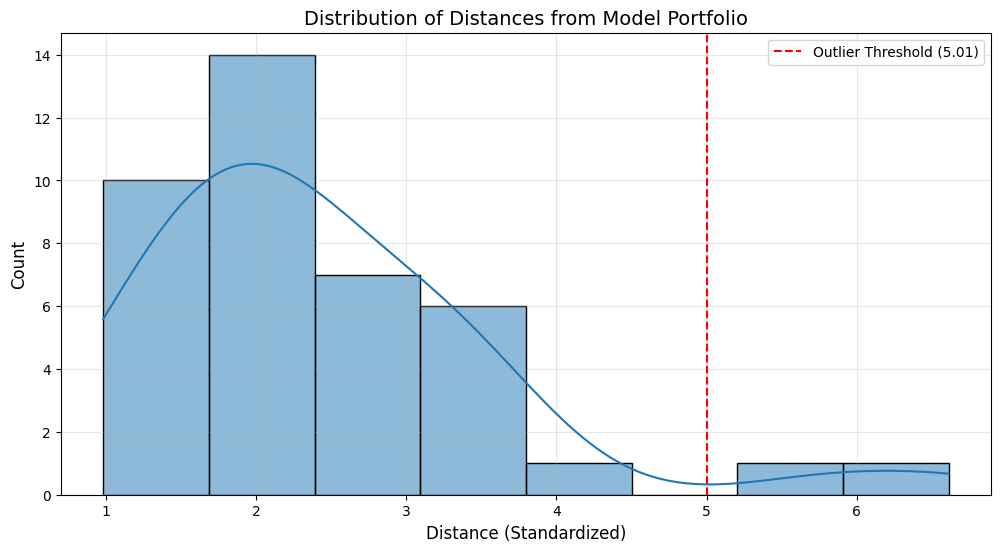

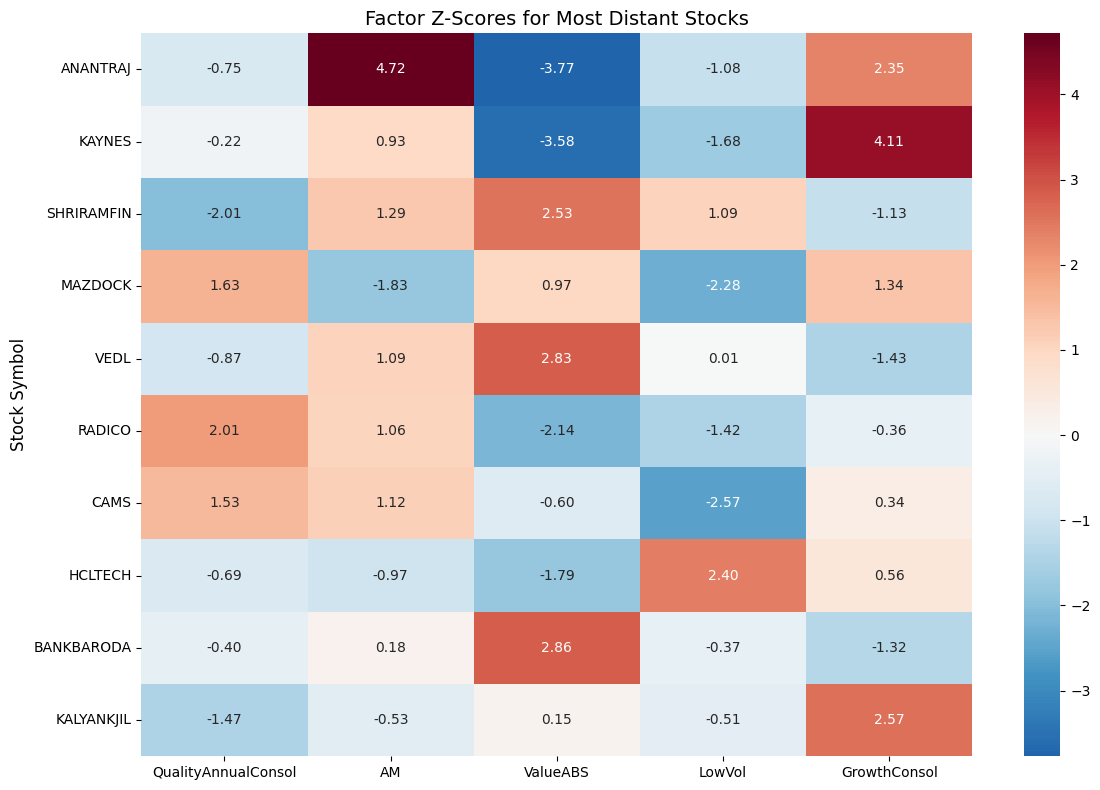

In [91]:
# 1. Analyze portfolio alignment
results = analyze_portfolio_alignment(liveexpsoures, modelexposures)

# 2. Print most misaligned stocks
print(results[results['is_outlier']].sort_values(by='distance', ascending=False))

# 3. Plot distance distribution
plot_distance_distribution(results)
plt.show()

# 4. Plot   contributions for top misaligned stocks
factor_cols = ['QualityAnnualConsol', 'AM', 'ValueABS', 'LowVol', 'GrowthConsol']
plot_factor_contributions(results, factor_cols, num_stocks=10)
plt.show()

In [89]:
results = analyze_portfolio_alignment(liveexpsoures, modelexposures)
results

,Symbol,distance,QualityAnnualConsol_zscore,AM_zscore,ValueABS_zscore,LowVol_zscore,GrowthConsol_zscore,is_outlier
1202,ANANTRAJ,6.612933,-0.751424,4.717040,-3.770651,-1.084289,2.349952,True
11436,KAYNES,5.787286,-0.222817,0.932905,-3.583317,-1.681891,4.111423,True
18660,SHRIRAMFIN,3.814628,-2.010532,1.286363,2.529793,1.086748,-1.128513,False
13242,MAZDOCK,3.733811,1.627473,-1.830756,0.974549,-2.278700,1.341191,False
22874,VEDL,3.460791,-0.867746,1.090165,2.828519,0.005179,-1.426565,False
17456,RADICO,3.449844,2.009283,1.058043,-2.144275,-1.419745,-0.362159,False
3610,CAMS,3.267949,1.525461,1.122466,-0.598504,-2.572369,0.342403,False
6018,HCLTECH,3.267170,-0.692903,-0.969933,-1.787273,2.396245,0.563190,False
2406,BANKBARODA,3.201461,-0.403035,0.182516,2.857012,-0.370842,-1.324223,False
10834,KALYANKJIL,3.055513,-1.474384,-0.531877,0.150442,-0.508814,2.568644,False
